# Small Pixel Fit
Use measurement data to get the conversion factors for the small pixels. The procedure is the following:
- Use a certain set of conversion factors for the large pixels in order to calculate their measured doses
- Since the small pixels should yield the same result, optimize their conversion factors on the dose of the large pixels
- Two optimization methods are tested:
    - Optimization for each detector separately
    - Optimization for the whole detector system

## Flags

In [1]:
POLY = False
INCLUDE_DATA = True

## Import Modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import importlib

from IPython.display import display, Markdown, display_html
import matplotlib.pyplot as plt
%matplotlib inline

### Custom Functions

In [3]:
import plot_csv_support as pcs
# importlib.reload(pcs)
reload(pcs)
import getConversionFactors as gcf
# importlib.reload(gcf)
reload(gcf)

<module 'getConversionFactors' from 'getConversionFactors.pyc'>

## Definitions

In [14]:
# Containing the measured data sets
inFolder = './smallPixel_Data/'

# Conversion factors for large pixels
conversionFactorsLarge = np.asarray( pcs.getConversionFactorsFile('conversionFit_wSim_10.csv') )

## Get dose- and energyCounts-vectors
Loop over subfolders to read in data and construct dose for large pixels

In [15]:
doseDict = {'dose': [], 'doseErr': []}
doseDictSingleList = [{'dose': [], 'doseErr': []}] * 3
energyCountsSmallList = []

measurementIndexList = []
measurementIndex = 0
for i in range(1, 7 + 1):
    if i == 7:
        folderName = 'PTBMay18/smallPixel/'
        smallOpt = False
    else:
        folderName = inFolder + 'Filter%d/' % i
        smallOpt = True

    # Get energy counts for large pixels
    energyCountsLargeDict = pcs.getEnergyCounts(folderName, large=True, smallOpt=smallOpt)
    doseDictLarge = pcs.getDose(energyCountsLargeDict['energyCounts'], conversionFactorsLarge)
    doseDictSingleListLarge = pcs.getDoseSingle(energyCountsLargeDict['energyCounts'], conversionFactorsLarge)

    doseDict['dose'] += list( doseDictLarge['dose'] )
    doseDict['doseErr'] += list( doseDictLarge['doseErr'] )

    for j in range(3):
        doseDictSingleList[j]['dose'] += list( doseDictSingleListLarge[j]['dose'] )
        doseDictSingleList[j]['doseErr'] += list( doseDictSingleListLarge[j]['doseErr'] )

    # Get energy counts for small pixels
    energyCountsSmall = pcs.getEnergyCounts(folderName, large=False, smallOpt=True)['energyCounts']
    energyCountsSmallList += list(energyCountsSmall)

    # Add the index values of the measurement to the list
    measurementIndexList.append( (measurementIndex, measurementIndex + len(energyCountsSmall)) )
    measurementIndex += len(energyCountsSmall)

doseListLarge = np.asarray( doseDict['dose'] )
print 'Total dose:', np.sum(doseListLarge)
doseErrListLarge = np.asarray( doseDict['doseErr'] )

print 'Length of dose vector:', len(doseDict['dose'])

Total dose: 136711.81596625084
Length of dose vector: 88


## Optimization of small pixels
### Via whole measured dose

In [16]:
if POLY:
    conversionFactorsSmall = gcf.evaluatePolyFitMono(np.arange(len(energyCountsSmallList)), np.asarray(energyCountsSmallList), np.asarray(doseListLarge), 16, DEGRange=np.arange(3, 6, 1), save='smallPixelAnalysis/polyFit')
else:
    if INCLUDE_DATA:
        energyList, energyListFile, energyCountsLarge, energyCountsErr, realDose = pcs.getCountsWrap('./PTBMay18/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], erlangen=False, angle=False, large=False)
        alphaList, kList = pcs.fitConversionSim(np.asarray(energyCountsLarge), np.asarray(realDose), [np.asarray(energyCountsSmallList)], [np.asarray(doseListLarge)], conversionFactorsLarge, werr=False)
        conversionFactorsSmall = pcs.getAlphaTot(alphaList, kList)
    else:
        conversionFactorsSmall = pcs.fitConversionNormal(np.asarray(energyCountsSmallList), np.asarray(doseListLarge), [0, np.inf], conversionFactorsLarge, werr=False)

Calculate the doses with the new conversion factors

In [18]:
doseDictSmall = pcs.getDose(energyCountsSmallList, conversionFactorsSmall)
doseListSmall, doseErrListSmall = doseDictSmall['dose'], doseDictSmall['doseErr']

Plot the response

In [19]:
def plotResponse(doseListLarge, doseListSmall, measurementIndexList, fnPostFix=''):
    fig, ax = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    idx = np.arange(len(doseListSmall))
    ax[0].set_yscale('log', nonposy='clip')
    # ax[1].set_yscale('symlog', nonposy='clip')

    for mIdx in measurementIndexList:
        mIdxLow, mIdxHigh = mIdx
        ax[0].errorbar(idx[mIdxLow:mIdxHigh], doseListLarge[mIdxLow:mIdxHigh], yerr=doseErrListLarge[mIdxLow:mIdxHigh], marker='x', color='#7fbf7b')
        ax[0].errorbar(idx[mIdxLow:mIdxHigh], doseListSmall[mIdxLow:mIdxHigh], yerr=doseErrListSmall[mIdxLow:mIdxHigh], marker='x', color='#af8dc3')

    # Empty plots for the legend labels
    ax[0].errorbar([], [], yerr=[], label='Large pixels', marker='x', color='#7fbf7b')
    ax[0].errorbar([], [], yerr=[], label='Small pixels', marker='x', color='#af8dc3')

    # Residual
    residualErr = 0 # doseListSmall/doseListLarge * np.sqrt(1./doseListSmall + 1./doseListLarge)
    ax[1].errorbar(idx, doseListSmall/doseListLarge - 1, yerr=residualErr, c='k', alpha=.7, marker='x')

    ax[1].set_xlabel('Measurement Index')
    ax[0].set_ylabel(r'$\mathrm{H_p}(10)$ ($\mu$Sv)')
    ax[1].set_ylabel('Residual')

    legend = ax[0].legend()
    frame = legend.get_frame()
    frame.set_alpha(1)

    ax[0].grid(which='both')
    ax[1].grid()
    ax[1].axhline(y = 0, c='k', lw=1, ls='--', alpha=.6)

    # Add vertical lines to indicate the different measurements
    for mIdx in measurementIndexList:
        mIdxLow, mIdxHigh = mIdx
        ax[0].axvline(x = mIdxLow, lw=1, ls='-.', c='k', alpha=.6)
        ax[0].axvline(x = mIdxHigh, lw=1, ls='-.', c='k', alpha=.6)

        ax[1].axvline(x = mIdxLow, lw=1, ls='-.', c='k', alpha=.6)
        ax[1].axvline(x = mIdxHigh, lw=1, ls='-.', c='k', alpha=.6)

    fnName = 'smallPixelAnalysis/small_vs_large_pixels'
    if POLY:
        fnName += '_poly'
    if INCLUDE_DATA:
        fnName += '_wData'
    
    fnName += fnPostFix
    fnName += '.pdf'

    fig.savefig(fnName)
    fig.show()

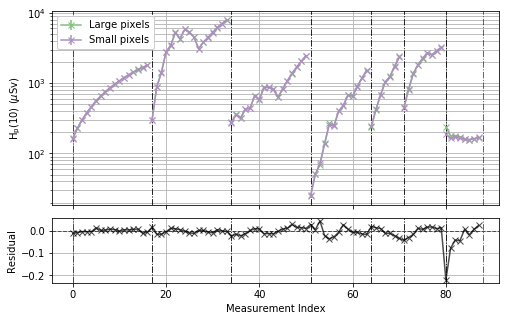

In [20]:
plotResponse(doseListLarge, doseListSmall, measurementIndexList)

Load PTB measurements in order to evaluate the new conversion factors

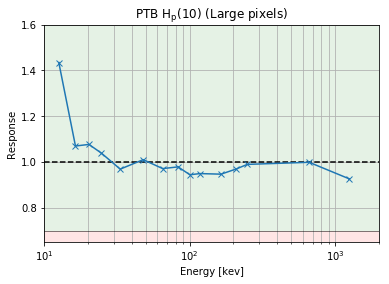

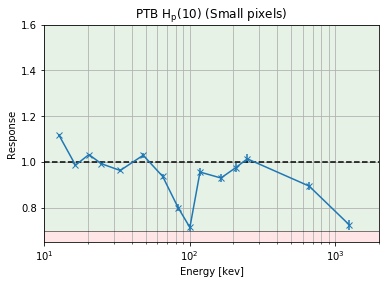

In [21]:
showDfPTBLarge = pcs.evaluateData('./PTBMay18/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], conversionFactors=conversionFactorsLarge, large=True)
showDfPTBSmall = pcs.evaluateData('./PTBMay18/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], conversionFactors=conversionFactorsSmall, large=False)

# showDfPTBLarge = pcs.evaluateData('./PTB_Daten/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], conversionFactors=conversionFactorsLarge, large=True)
# showDfPTBSmall = pcs.evaluateData('./PTB_Daten/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], conversionFactors=conversionFactorsSmall, large=False)

fnNameLarge, fnNameSmall = 'smallPixelAnalysis/Hp10_large_May_G4', 'smallPixelAnalysis/Hp10_small_May_G4'
if POLY:
    fnNameLarge += '_poly'
    fnNameSmall += '_poly'
if INCLUDE_DATA:
    fnNameLarge += '_wData'
    fnNameSmall += '_wData'
    
fnNameLarge += '.pdf'
fnNameSmall += '.pdf'
    
pcs.plotDose(showDfPTBLarge, r'PTB $\mathrm{H_p(10)}$ (Large pixels)', ylim=(0.65, 1.6), save=fnNameLarge)
pcs.plotDose(showDfPTBSmall, r'PTB $\mathrm{H_p(10)}$ (Small pixels)', ylim=(0.65, 1.6), save=fnNameSmall)

### Via single detector dose
Split total dose in component for each detector.
Start with large pixels:

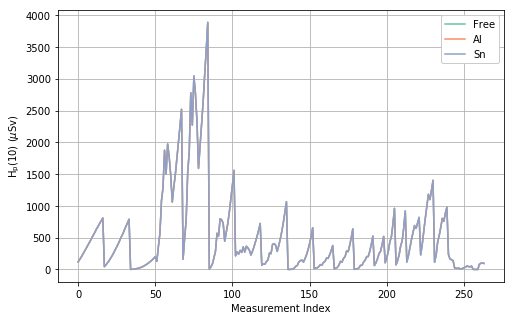

In [22]:
doseSingleMatrix = []
for i in range(len(doseDictSingleList[0]['dose'])):
    row = []
    for j in range(3):
        row.append( doseDictSingleList[j]['dose'][i] )
    doseSingleMatrix.append( row )
    
fig, ax = plt.subplots(figsize=(8, 5))

labelList = ('Free', 'Al', 'Sn')
colorList = ['#66c2a5', '#fc8d62', '#8da0cb']
for i in range(3):
    data = np.asarray(doseSingleMatrix)[:, i]
    ax.plot(np.arange(len(data)), data, label=labelList[i], color=colorList[i])
    
ax.set_xlabel('Measurement Index')
ax.set_ylabel(r'$\mathrm{H_p}(10)$ ($\mu$Sv)')
ax.grid()

legend = ax.legend()
frame = legend.get_frame()
frame.set_alpha(1)

fig.show()

Small pixels:

In [23]:
energyCountsSmallMatrix = []
for energyCountsSmall in energyCountsSmallList:
    energyCountsSmallMatrix.append( [energyCountsSmall[:16], energyCountsSmall[16:32], energyCountsSmall[32:]] )
print np.asarray( energyCountsSmallMatrix )[:,0]

[[    0     0     0 ... 13483 10097  4105]
 [    0     0     0 ... 16883 12531  5366]
 [    0     0     0 ... 19552 15035  6430]
 ...
 [    0     1     7 ...   660   697   370]
 [    0     0     5 ...   468   530   305]
 [    0     0    11 ...   369   395   249]]


### Fit conversion factors

In [41]:
if INCLUDE_DATA:
    energyList, energyListFile, energyCountsSmall, energyCountsErr, realDose = pcs.getCountsWrap('./PTBMay18/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], erlangen=False, angle=False, large=False)
    energyCountsMatrix = []
    for i in range(len(energyCountsSmall)):
        energyCountsMatrix.append( [energyCountsSmall[i][:16], energyCountsSmall[i][16:32], energyCountsSmall[i][32:]] )

    realDoseMatrix = np.asarray( [elm['dose'] for elm in pcs.getDoseSingle(energyCountsLarge, conversionFactorsLarge)] ).T
    print realDoseMatrix

conversionFactorsSingleSmall = []
for i in range(3):
    if INCLUDE_DATA:
        alphaList, kList = pcs.fitConversionSim(np.asarray(energyCountsMatrix)[:, i], np.asarray(realDoseMatrix)[:, i], [np.asarray(energyCountsSmallMatrix)[:, i]], [np.asarray(doseSingleMatrix[i*len(energyCountsSmallMatrix):(i+1)*len(energyCountsSmallMatrix)])[:, i]], conversionFactorsLarge[16*i:16*(i+1)], werr=False)
        conversionFactorsSingleSmall += list( pcs.getAlphaTot(alphaList, kList) )
    else:
        conversionFactorsSingleSmall += list( pcs.fitConversionNormal(np.asarray(energyCountsSmallMatrix)[:, i], np.asarray(doseSingleMatrix)[:, i], [0, np.inf], conversionFactorsLarge[16*i:16*(i+1)], werr=False) )
conversionFactorsSingleSmall = np.asarray(conversionFactorsSingleSmall)

[[3.33310653 0.03473517 0.        ]
 [2.3983125  0.26874501 0.        ]
 [2.09051771 0.93703005 0.        ]
 [1.92404642 1.61513829 0.        ]
 [1.47078426 2.56688296 0.02664691]
 [1.53323583 3.24099647 0.31216525]
 [1.59015017 3.86755936 0.75937962]
 [1.08529533 2.78545861 1.16209526]
 [0.74552244 1.96630537 1.14943298]
 [0.76729303 2.154422   1.27128347]
 [0.59219408 1.57149182 1.64961894]
 [0.65960942 1.67372787 1.72345245]
 [0.7025346  1.83059851 1.66611705]
 [0.76129534 1.85511639 1.23848312]
 [0.42360742 0.90512197 0.52808989]]


In [40]:
np.asarray(doseSingleMatrix[i*len(energyCountsSmallMatrix):(i+1)*len(energyCountsSmallMatrix)])[:, i].shape

(88,)

In [35]:
print np.asarray( energyCountsMatrix ).shape
print np.asarray(realDoseMatrix).shape
print np.asarray(energyCountsSmallMatrix).shape
print np.asarray(doseSingleMatrix[len(energyCountsSmallMatrix):2*len(energyCountsSmallMatrix)]).shape

(15, 3, 16)
(15, 3)
(88, 3, 16)
(88, 3)


Calculate the doses with the new conversion factors

In [42]:
doseDictSingleSmall = pcs.getDose(energyCountsSmallList, conversionFactorsSingleSmall)
doseListSingleSmall, doseErrListSingleSmall = doseDictSingleSmall['dose'], doseDictSingleSmall['doseErr']

### Plot response

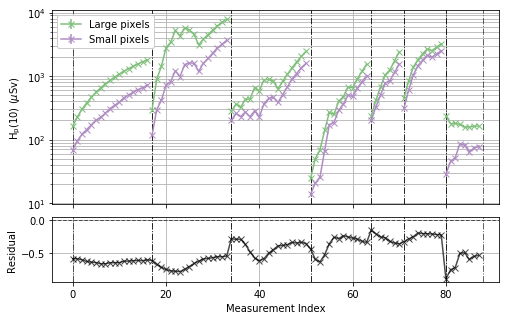

In [43]:
plotResponse(doseListLarge, doseListSingleSmall, measurementIndexList, fnPostFix='_single')

Load PTB measurements in order to evaluate the new conversion factors

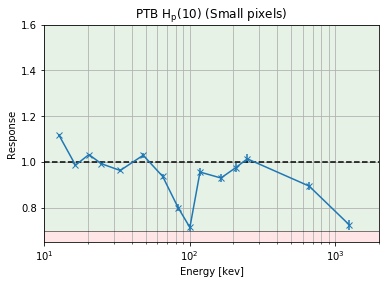

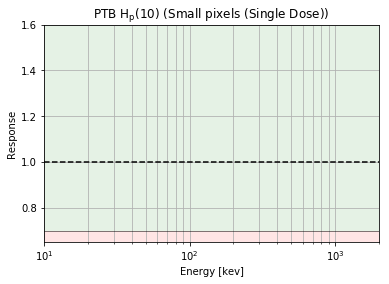

In [45]:
showDfPTBSmallSingle = pcs.evaluateData('./PTB_Daten2/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], conversionFactors=conversionFactorsSingleSmall, large=False)
# showDfPTBSmallSingle = pcs.evaluateData('./PTB_Daten/Energie/', '01_Energien_Daten.txt', header=['Energy', 'MeanEnergy', 'theo'], conversionFactors=conversionFactorsSingleSmall, large=False)
fnNameSmallSingle = 'smallPixelAnalysis/Hp10_small'
if POLY:
    fnNameSmallSingle += '_poly'
if INCLUDE_DATA:
    fnNameSmallSingle += '_wData'
    
fnNameSmallSingle += '_single.pdf'
    
pcs.plotDose(showDfPTBSmall, r'PTB $\mathrm{H_p(10)}$ (Small pixels)', ylim=(0.65, 1.6), save=None)
pcs.plotDose(showDfPTBSmallSingle, r'PTB $\mathrm{H_p(10)}$ (Small pixels (Single Dose))', ylim=(0.65, 1.6), save=None) # fnNameSmallSingle)

## Save conversion factors

### Small total

In [41]:
outDf = pcs.conversionFactorsToDf(conversionFactorsSmall)
display(outDf)
outDfFn = 'smallPixelAnalysis/conversionSmall'
if INCLUDE_DATA:
    outDfFn += '_wData'
if POLY:
    outDfFn += '_poly'
    
outDfFn += '0_07.csv'

outDf.to_csv(outDfFn, header=None, index=False)

Slot1     Slot2     Slot3
0   1.178554e-02  0.017472  0.002370
1   9.368851e-04  0.004909  0.001564
2   2.230142e-03  0.003781  0.002892
3   6.506097e-02  0.068375  0.008043
4   9.257653e-02  0.097665  0.028471
5   1.607143e-02  0.016736  0.054146
6   1.319537e-02  0.015196  0.030437
7   1.615874e-02  0.010427  0.049232
8   2.046303e-02  0.007319  0.070534
9   5.710858e-03  0.004517  0.061299
10  3.792504e-03  0.003343  0.027905
11  4.186310e-03  0.003741  0.033189
12  2.616524e-03  0.004995  0.031271
13  5.151433e-03  0.002226  0.020404
14  2.967909e-08  0.000575  0.025344
15  1.717994e-02  0.001251  0.086838

### Small single

In [78]:
outDfSingle = pcs.conversionFactorsToDf(conversionFactorsSingleSmall)
display(outDfSingle)

outDfFnSingle = 'smallPixelAnalysis/conversionSmall_single'
if INCLUDE_DATA:
    outDfFnSingle += '_wData'
if POLY:
    outDfFnSingle += '_poly'
    
outDfFnSingle += '.csv'

outDfSingle.to_csv('smallPixelAnalysis/conversionSmall_single.csv', header=None, index=False)

Slot1         Slot2     Slot3
0   2.543895e-03  6.303330e-05  0.021132
1   2.267612e-03  1.839636e-05  0.049868
2   8.531514e-07  1.510424e-05  0.011317
3   6.009168e-07  1.238869e-05  0.009218
4   4.397161e-07  2.820743e-06  0.012797
5   3.443478e-07  2.740529e-06  0.253367
6   1.939563e-07  1.091111e-04  0.104923
7   4.031360e-05  1.844487e-01  0.247867
8   5.852323e-02  6.402811e-02  0.092983
9   1.931890e-02  2.513574e-03  0.026875
10  6.537280e-03  2.374864e-02  0.060162
11  1.253538e-02  1.200612e-02  0.069891
12  1.999579e-03  8.597785e-03  0.067651
13  4.229207e-03  4.345322e-07  0.039496
14  2.806824e-03  1.162255e-03  0.013149
15  2.574989e-07  1.084644e-02  0.017321